In [1]:
import os
import math
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Hàm lấy dữ liệu từ CoinGecko

In [2]:
def get_historical_data(coin_id, vs_currency, days):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

### Hàm xây dựng và dự đoán giá trị với mô hình XGBoost

In [3]:
def predict_and_save(coin_id, vs_currency, days, file_path):
    # Kiểm tra và tạo thư mục nếu cần
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    df = get_historical_data(coin_id, vs_currency, days)
    data = df.filter(['price'])
    dataset = data.values
    training_data_len = math.ceil(len(dataset) * .8)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[0:training_data_len, :]
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)
    model.fit(x_train, y_train)

    test_data = scaled_data[training_data_len - 60:, :]
    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)

    predictions = model.predict(x_test)
    predictions = predictions.reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)

    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16, 8))
    plt.title(f'Model {coin_id.upper()}-{vs_currency.upper()} XGBoost')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['price'], label='Train')
    plt.plot(valid['price'], label='Val')
    plt.plot(valid['Predictions'], label='Predictions')
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

    valid['Date'] = valid.index
    results = valid[['Date', 'price', 'Predictions']]
    results.to_csv(file_path, index=False)

    rmse = np.sqrt(mean_squared_error(valid['price'], valid['Predictions']))
    mae = mean_absolute_error(valid['price'], valid['Predictions'])
    mape = np.mean(np.abs((valid['price'] - valid['Predictions']) / valid['price'])) * 100

    print(f'{coin_id.upper()}-{vs_currency.upper()} XGBoost RMSE: {rmse}')
    print(f'{coin_id.upper()}-{vs_currency.upper()} XGBoost MAE: {mae}')
    print(f'{coin_id.upper()}-{vs_currency.upper()} XGBoost MAPE: {mape}%')

### Dự đoán cho các cặp tiền với XGBoost

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6608\2613050549.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


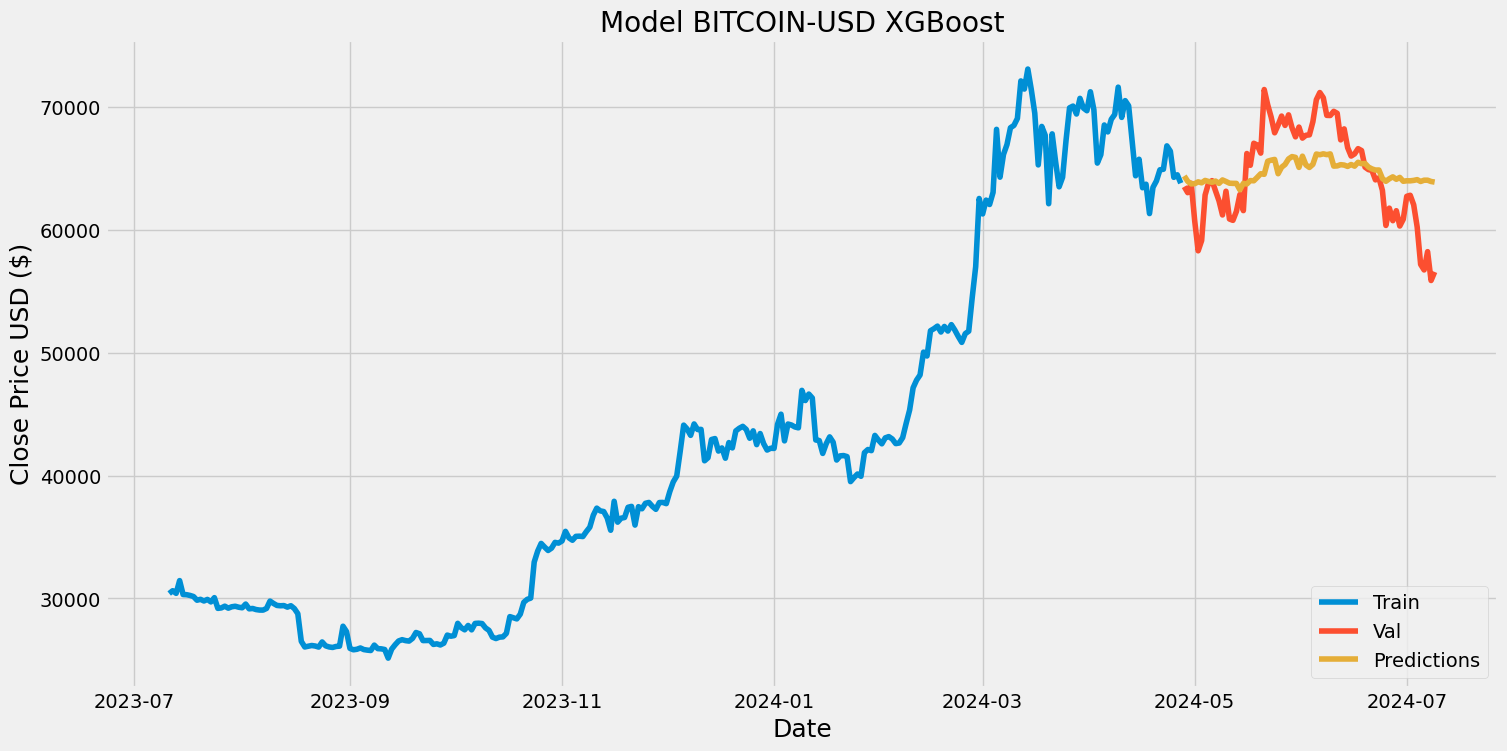

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6608\2613050549.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = valid.index


BITCOIN-USD XGBoost RMSE: 3313.31679262597
BITCOIN-USD XGBoost MAE: 2725.9139677437693
BITCOIN-USD XGBoost MAPE: 4.270971477134121%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6608\2613050549.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


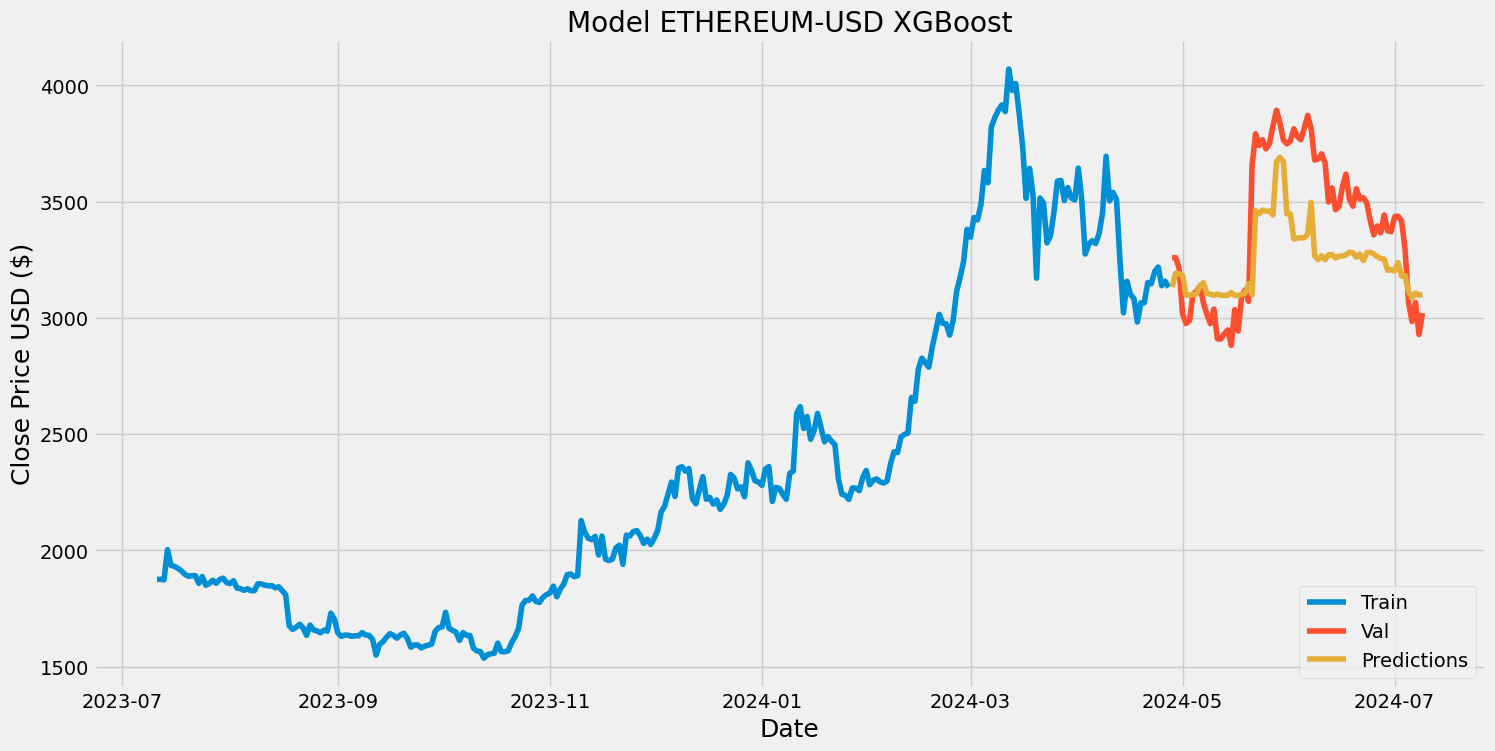

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6608\2613050549.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = valid.index


ETHEREUM-USD XGBoost RMSE: 249.1005479784197
ETHEREUM-USD XGBoost MAE: 209.4132465167812
ETHEREUM-USD XGBoost MAPE: 5.960443524512801%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6608\2613050549.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


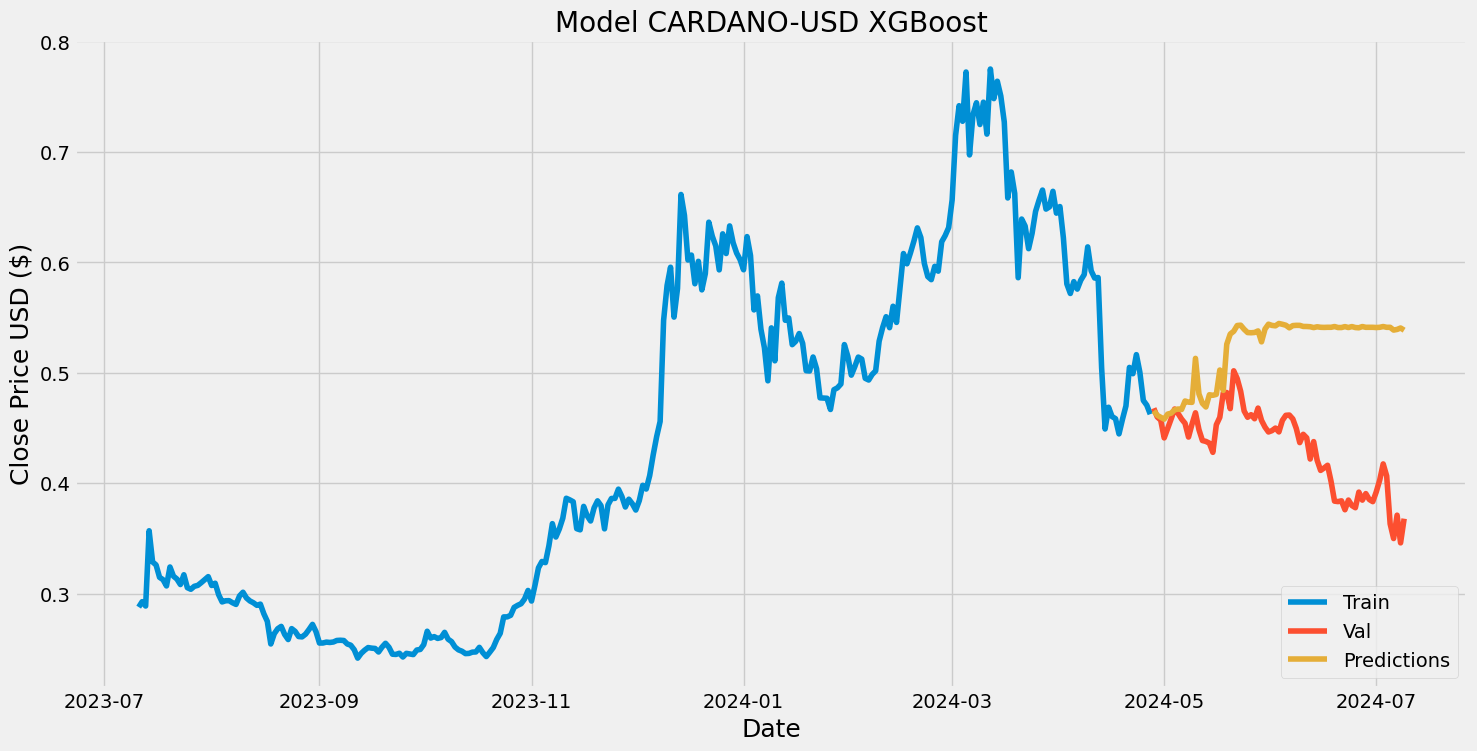

CARDANO-USD XGBoost RMSE: 0.10578050482030289
CARDANO-USD XGBoost MAE: 0.08964766015462414
CARDANO-USD XGBoost MAPE: 21.94606791607735%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6608\2613050549.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = valid.index


In [4]:
# Dự đoán và lưu kết quả cho BTC-USD
predict_and_save('bitcoin', 'usd', '365', '../output/XGBoost/BTC-USD.csv')

# Dự đoán và lưu kết quả cho ETH-USD
predict_and_save('ethereum', 'usd', '365', '../output/XGBoost/ETH-USD.csv')

# Dự đoán và lưu kết quả cho ADA-USD
predict_and_save('cardano', 'usd', '365', '../output/XGBoost/ADA-USD.csv')